# Personalized PageRank
The idea of this R notebook is to implement the Personalized Pagerank Algorithm (PPR) developed by Reid Andersen in *http://www.leonidzhukov.net/hse/2016/networks/papers/andersen06localgraph.pdf*. 

This algorithm selects a vertex of the graph and uses it as a starting point. Assignes the entire rank to it and then *Squeeshes* it and sees where the rank went. If we iterate this process, only the nodes inside the cluster will have positive pagerank.

## Single step Personalized PageRank

In [73]:
#Defines a function that given a starting vertex,
#Calculates its surrounding cluster

#' @param adj The adjacency matrix of the current graph
#' @param vertex The index of the initial vertex
#' @param alpha Float between 0 and 1, corresponding 
#               to the alpha value in PPR
#' @param eps Float larger than zero. The epsylon value 
#             indicating when to stop squeeshing.
#'
#' @return A list, where each coordiante contains the 
#               set of vertex index in that cluster

find_cluster_ppr = function(adj, vertex, alpha = 0.5, eps = 0.001){
  
  #declares the number of vertices
  N = dim(adj)[1]
  if(vertex < 1){
    stop(paste('Vertex index cannot be less than 1: index = ',
               vertex, 
               ' of N = ', 
               N, 
               sep = '' ))
  }
  if(vertex > N){
    stop(paste('Vertex larger than num. elements: index = ', 
               vertex, ' of N = ', N, sep = '' ))
  }
  #Array with indices
  indices = 1:N
  #Initializes the rank and the residue
  rank = rep(0,N)
  residue = rep(0,N)
  residue[vertex] = 1
  #out going degree array
  degree = rowSums(adj)
  if(min(degree) == 0){
    stop('The minimum outdegree of every node 
            must be at least one (all must include self loops)')
  }
  
  #Division od residue/degree
  eps_vector = residue/degree
  flag = max(eps_vector) >= eps

  if(!flag){
    return(vertex)
  }
  
  while(flag){
    
    #Gets max
    index = which.max(eps_vector)
    #Extracts residue and sets it to zero
    res = residue[index]
    residue[index] = 0
    #updates own rank
    rank[index] = rank[index] + alpha*res
    neighbors = indices[as.logical(adj[index,])]
    V = length(neighbors)
    #print(V)
    plus = (1- alpha)*res/(2*V)
    residue[neighbors] = residue[neighbors] + plus
    
    eps_vector = residue/degree
    flag = max(eps_vector) >= eps                
  }
  
  return(indices[which(rank > 0)])
  
}

### An Example
Here is a small example of the behaviour of this function in a given graph

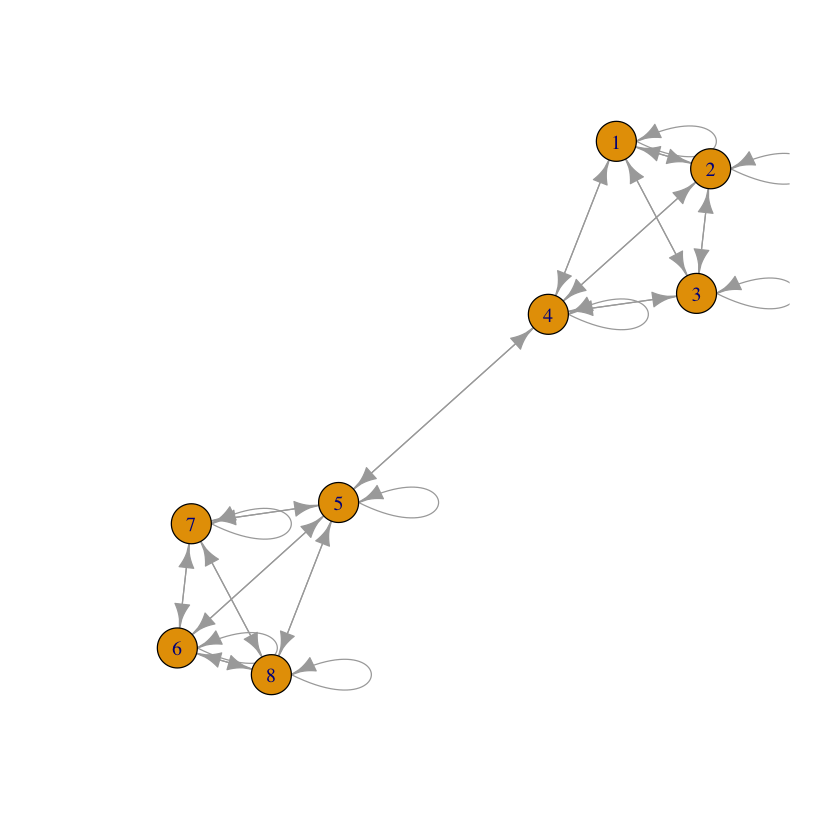

In [51]:
#Imports Igraph for plotting
library(igraph)
#Example graph
adj_1 = c(1,1,1,1,0,0,0,0)
adj_4 = c(1,1,1,1,1,0,0,0)
adj_5 = c(0,0,0,1,1,1,1,1)
adj_6 = c(0,0,0,0,1,1,1,1)
A = matrix( c(adj_1,
              adj_1,
              adj_1,
              adj_4,
              adj_5,
              adj_6,
              adj_6,
              adj_6),nrow=8, byrow = TRUE)
g = graph.adjacency(A)
plot(g)

If we excecute the PPR procedure from vertex 1, we should get the lower clique, like this

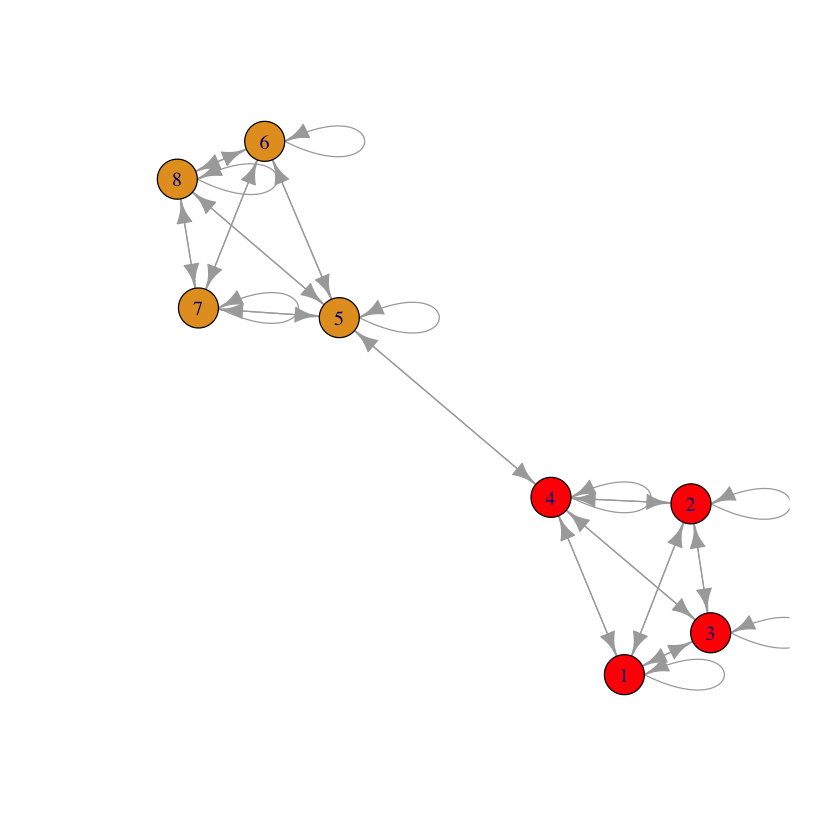

In [55]:
clust = find_cluster_ppr(A,1)
V(g)$color = '#e49e25'
V(g)$color[clust] = '#ff0000'
plot(g)

## Iterative Personalized PageRank
We implement the complete procedure, where seed nodes are selected at random

In [66]:
#Defines a function that given an adjacency matrix,
#Calculates all clusters inside it

#' @param adj The adjacency matrix of the current graph
#' @param alpha Float between 0 and 1, 
#         corresponding to the alpha value in PPR
#' @param eps Float larger than zero.  The epsylon 
#         value indicating when to stop squeeshing.
#'
#' @return A list, where each coordiante contains 
#           the set of vertex index in that cluster

iterative_ppr = function(adj, alpha = 0.5, eps = 0.001){
  
  #Exctracts the dimension
  N = dim(adj)[1]
  #Declares indices
  indices = 1:N
  #declares unused indices
  unused = 1:N
  
  clusters = list()
  num_clusters = 0
  while(length(unused) > 0){
    
    #Extract a random element
    vertex = sample(1:length(unused),1)
    adj_temp = adj[unused,unused]
    #finds clusters
    selected = unused[find_cluster_ppr(adj_temp, 
                                       vertex, 
                                       alpha = alpha, 
                                       eps = eps)]
    print(paste('Cluster of size: ', 
                length(selected), 
                ' found. Nodes to go: ', 
                length(unused), sep = ''))
    #adds cluster
    num_clusters = num_clusters + 1
    clusters[[num_clusters]] = selected
    #Removes the found vertices
    unused = setdiff(unused,selected)
    print(paste('Cluster of size: ', 
                length(selected), 
                ' found. Nodes to go: ', 
                length(unused), sep = ''))
    if(length(unused) == 1){
      num_clusters = num_clusters + 1
      clusters[[num_clusters]] = unused
      unused = c()
    }
  }
  
  return(clusters)
  
}

### Final Example
We now compute all clusters inside our example.

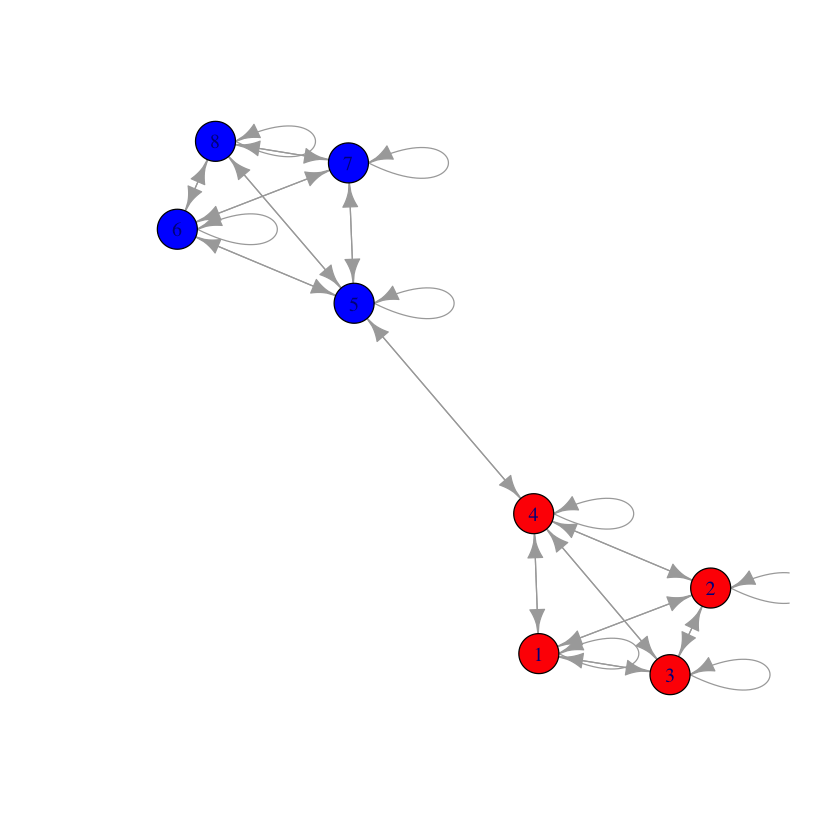

In [72]:
clust = iterative_ppr(A)
V(g)$color = '#e49e25'
colors = c('#ff0000','#0000ff','#00ff00')
for(i in 1:length(clust)){
    V(g)$color[clust[[i]]] = colors[i]
}
plot(g)
